# DATA512 - A1: 
# Collect and Analyze Monthly Page Views with the Wikipedia API

This project uses the Pagecounts and Pageviews APIs documented in Step 1 below to query for the number of Wikipedia views in recent years.  This reproducible analysis culminates with a plot of mobile, desktop, and total Wikipedia traffic over the course of these years.

Please note the markdown at each step of the analysis for information on data, parameters, file formats, processing steps, and additional considerations for understanding the analysis.

### Imports
Import standard Python libraries which can be installed via `pip` or `conda`.

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# Step 1: Data Aquisition
- Sample code for accessing the Wikipedia API was made available for re-use under a CC0 license.
- Wikimedia Foundation REST API terms of use: https://www.mediawiki.org/wiki/REST_API#Terms_and_conditions
- Legacy Pagecounts API: https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts
- Modern Pageviews API: https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews

**Note:** Because the Pageview API makes it possible to filter for user traffic only, there is a slight discrepency in the counts of hits in the years for which both Pagecount and Pageview results exist.  This impacts the final analysis, as the results from the Pagecount API might include bot and web crawler traffic.

### Set API Parameters
Set the parameters required for accessing page views with the old and new API.
- For end parameter, use 1st day of month following final month of data
- Pagecounts API denoted as legacy
- Current API denoted by name as Pageviews

In [2]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:
desktop_legacy_params = {"project" : "en.wikipedia.org",
                         "access-site" : "desktop-site",
                         "granularity" : "monthly",
                         "start" : "2007120100",
                         "end" : "2016080100"}

In [4]:
mobile_legacy_params = {"project" : "en.wikipedia.org",
                        "access-site" : "mobile-site",
                        "granularity" : "monthly",
                        "start" : "2007120100",
                        "end" : "2016080100"}

In [5]:
desktop_pageview_params = {"project" : "en.wikipedia.org",
                          "access" : "desktop",
                          "agent" : "user",
                          "granularity" : "monthly",
                          "start" : "2015070100",
                          "end" : '2019090100'}

In [6]:
mobile_web_pageview_params = {"project" : "en.wikipedia.org",
                              "access" : "mobile-web",
                              "agent" : "user",
                              "granularity" : "monthly",
                              "start" : "2015070100",
                              "end" : '2019090100'}

In [7]:
mobile_app_pageview_params = {"project" : "en.wikipedia.org",
                              "access" : "mobile-app",
                              "agent" : "user",
                              "granularity" : "monthly",
                              "start" : "2015070100",
                              "end" : '2019090100'}

In [8]:
headers = {'User-Agent': 'https://github.com/jstreme',
           'From': 'jstremme@uw.edu'}

### Make API Calls
Make the series of API calls covering desktop and mobile access via the legacy and new APIs.

In [9]:
def api_call(endpoint, parameters, headers):
    
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [10]:
results = [api_call(endpoint_legacy, desktop_legacy_params, headers),
           api_call(endpoint_legacy, mobile_legacy_params, headers),
           api_call(endpoint_pageviews, desktop_pageview_params, headers),
           api_call(endpoint_pageviews, mobile_web_pageview_params, headers),
           api_call(endpoint_pageviews, mobile_app_pageview_params, headers)]

### Save Results JSONS
Define the file names for saving the API call results and iteratively save each result.

In [11]:
file_paths = ['pagecounts_desktop-site_200712-201608.json',
              'pagecounts_mobile-site_200712-201608.json',
              'pageviews_desktop_201507-201909.json',
              'pageviews_mobile-web_201507-201909.json',
              'pageviews_mobile-app_201507-201909.json']

In [12]:
for i in range(0, len(results)):
    with open('data/'+file_paths[i], 'w') as f:
        json.dump(results[i], f)

# Step 2: Data Processing
Aggregate the information from the various API calls into a single, user-friendly CSV files containing Desktop and Mobile page view counts from both the legacy and new pageview Wikipedia APIs.

### Load JSONS
Load each JSON file.

In [13]:
data = []
for i in range(0, len(results)):
    with open('data/'+file_paths[i], 'r') as f:
        data.append(json.load(f))

### Convert to Pandas Dataframes
Convert dictionaries of data to dataframes for easier processing.

In [14]:
dfs = [pd.DataFrame(data[i]['items']) for i in range(0, len(data))]

### Unpack Dataframes and Combine Mobile-App and Mobile-Web Data from Pageviews API
Save the legacy and new API results from mobile and desktop, and add mobile-app and mobile-web results from the new API.

In [15]:
legacy_desktop = dfs[0]
legacy_mobile = dfs[1]
pageviews_desktop = dfs[2]

In [16]:
pageviews_mobile = dfs[3].copy()
pageviews_mobile['access'] = 'mobile'
pageviews_mobile['views'] = dfs[3]['views'] + dfs[4]['views']

### Create Total Counts Dataframe and Split out Years and Months
Start building a dataframe of combined values by tracking months and years.

In [17]:
total_df = pd.DataFrame({'timestamp': 
                         legacy_desktop['timestamp'].append(pageviews_desktop['timestamp']).drop_duplicates()})

In [18]:
total_df['year'] = total_df['timestamp'].apply(lambda x: x[0:4])
total_df['month'] = total_df['timestamp'].apply(lambda x: x[4:6])
total_df = total_df.drop('timestamp', 1)

### Add the views from the Legacy API
Note that zeros are inserted on months for which the legacy API no longer recorded values.

In [19]:
total_df['pagecount_desktop_views'] = np.concatenate([legacy_desktop['count'].values, 
                                                      np.zeros(len(total_df) - len(legacy_desktop))])

In [20]:
total_df['pagecount_mobile_views'] = np.concatenate([np.zeros(len(legacy_desktop) - len(legacy_mobile)),
                                                     legacy_mobile['count'].values, 
                                                     np.zeros(len(total_df) - len(legacy_desktop))])

In [21]:
total_df['pagecount_all_views'] = total_df['pagecount_desktop_views'] + total_df['pagecount_mobile_views']

### Add the views from the Pageviews API
Note that zeros are inserted on months for which the Pageviews API was not active.

In [22]:
total_df['pageview_desktop_views'] = np.concatenate([np.zeros(len(total_df) - len(pageviews_desktop)), 
                                                      pageviews_desktop['views'].values])
total_df['pageview_mobile_views'] = np.concatenate([np.zeros(len(total_df) - len(pageviews_mobile)), 
                                                      pageviews_mobile['views'].values])
total_df['pageview_all_views'] = total_df['pageview_desktop_views'] + total_df['pageview_mobile_views']

### Save Dataframe
Save a user-friendly CSV file with the following fields:


- Column | Value
- year | YYYY
- month | MM
- pagecount_all_views | num_views
- pagecount_desktop_views | num_views
- pagecount_mobile_views | num_views
- pageview_all_views | num_views
- pageview_desktop_views | num_views
- pageview_mobile_views | num_views

In [23]:
total_df.to_csv('data/en-wikipedia_traffic_200712-201809.csv', index=False)

# Step 3: Analysis
View time series of page views.

**Note**: Because the Pageview API makes it possible to filter for user traffic only, there is a slight discrepency in the counts of hits in the years for which both Pagecount and Pageview results exist.  This impacts the visualization below, as the results from the Pagecount API might include bot and web crawler traffic.  In cases where API results exist for both the Pagecount and Pageview APIs, the Pageview results are displayed.

See the `wiki_views.png` file to view the visualization.

### Load Data to Create Plot
Load the CSV.

In [24]:
views_df = pd.read_csv('data/en-wikipedia_traffic_200712-201809.csv')

### Collect Total Desktop and Mobile Traffic for Each Month Using Both APIs
Prefer the new API if both are populated for a given month, as we have applied the user only filter with the new API to avoid counting bots and web crawlers.

In [25]:
def dedupe_apis(api_tuple):
    
    if api_tuple[1] == 0:
        return api_tuple[0]
    else: 
        return api_tuple[1]

In [26]:
views_df['mobile_traffic'] = list(zip(views_df['pagecount_mobile_views'].tolist(),
                                      views_df['pageview_mobile_views'].tolist()))
views_df['mobile_traffic'] = views_df['mobile_traffic'].apply(dedupe_apis)

In [27]:
views_df['desktop_traffic'] = list(zip(views_df['pagecount_desktop_views'].tolist(),
                                       views_df['pageview_desktop_views'].tolist()))
views_df['desktop_traffic'] = views_df['desktop_traffic'].apply(dedupe_apis)

### Compute Total Traffic from both Desktop and Mobile
This will be plotted as the total amount of traffic per month.

In [28]:
views_df['all_traffic'] = views_df['desktop_traffic'] + views_df['mobile_traffic']

### Create Global Year and Month Dictionary and Lookup Function for Labeling Plot
This will help with annotating the X-axis of the plot.

In [29]:
year_month_dict = views_df['year'].apply(str) + '-' + views_df['month'].apply(str)

In [30]:
def create_year_month_tick(value, tick):
    return year_month_dict[value]

### Display Plot in Notebook and Save as PNG
Track:
- Mobile traffic
- Desktop traffic
- All traffic

Comments indicate operations performed to create an easy-to-understand visualization.

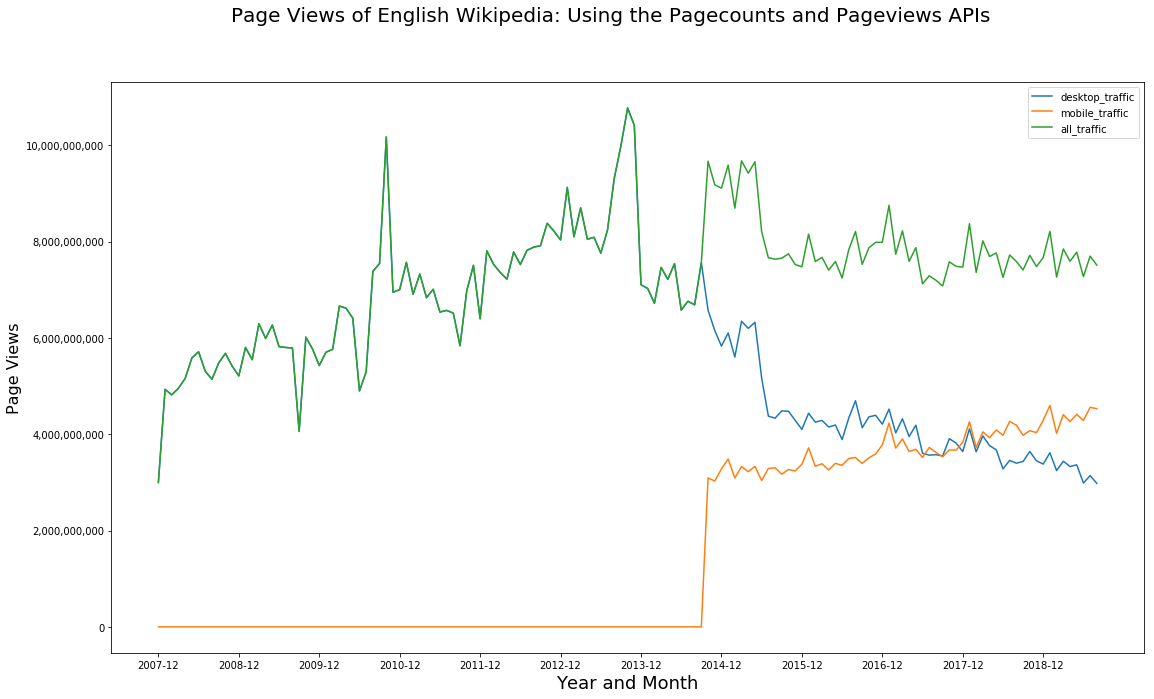

In [31]:
# Create figure and add data
fig, ax = plt.subplots()
ax.plot(views_df['desktop_traffic'])
ax.plot(views_df['mobile_traffic'])
ax.plot(views_df['all_traffic'])

# Create legend with attributes corresponding to plotted data
fig.gca().legend(('desktop_traffic', 'mobile_traffic', 'all_traffic'))

# Format ticks
ax.ticklabel_format(style='plain')
plt.xticks(np.arange(0, len(views_df)+1, 12))
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(create_year_month_tick))

# Add X, Y labels and title
fig.suptitle('Page Views of English Wikipedia: Using the Pagecounts and Pageviews APIs', fontsize=20)
plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Page Views', fontsize=16)

# Format size
fig.set_size_inches(18.5, 10.5, forward=True)

# Save figure and display in notebook
fig.savefig('wiki_views.png', dpi=100)
plt.show()